# Two-dimensional shallow water model

## Part 1: Building numerical code

Momentum equations:

$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - g \frac{\partial \eta}{\partial x} + \frac{\tau_{wx}}{\rho h} - \frac{\tau_{bx}}{\rho h} + fv + \frac{F_x}{\rho h} + \nu_H \nabla^2 u $$

$$ \underbrace{\frac{\partial v}{\partial t}}_{\text{inert.}} + \underbrace{u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y}}_{\text{convec.}} = \underbrace{- g \frac{\partial \eta}{\partial y}}_{\text{gravit.}} + \underbrace{\frac{\tau_{wy}}{\rho h} - \frac{\tau_{by}}{\rho h}}_{\text{shear stresses}} - \underbrace{fu}_{\text{Cor.}} + \underbrace{\frac{F_y}{\rho h}}_{\text{wave}} + \underbrace{\nu_H \nabla^2 v}_{\text{eddy diff.}} $$

Continuity equation:
$$ \frac{\partial \eta}{\partial t} + \frac{\partial (hu)}{\partial x} + v \frac{\partial (hv)}{\partial y} = 0 $$

For demonstration purpose, only inertial and convective accelerations, and gravity and bed shear stress are considered. 

$ \tau_b = \rho U_\ast^2 = \rho g U^2 / C^2 $

In [7]:
M = 50
N = 100
zb = zeros(M,N) - 10
Δx = 50
Δy = 100
Δt = 1.0
CFL = 0.8  # should be < 1

0.8

In [8]:
C = 50
ρ = 1025
g = 9.81
νH = 1.0

1.0

In [9]:
# assume that we know u, v

uu = -1.5 + 0.1*rand(M+1,N) 
vv = 0.5 + 0.2*rand(M,N+1) 
x = zeros(M,N)
y = zeros(M,N)
for i = 1:M
    for j = 1:N
        x[i,j] = (i-1)*Δx
        y[i,j] = (j-1)*Δy
    end
end
# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.5*rand(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)

# Solve the continuity equation 
NT = 20
ETA = zeros(M,N,NT)
for i = 1:NT
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # volume fluxes in x and y directions
    qx = uu .* hu
    qy = vv .* hv

    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    # η = η1
    ETA[:,:,NT] = η1
end
# ETA[:,:,NT]

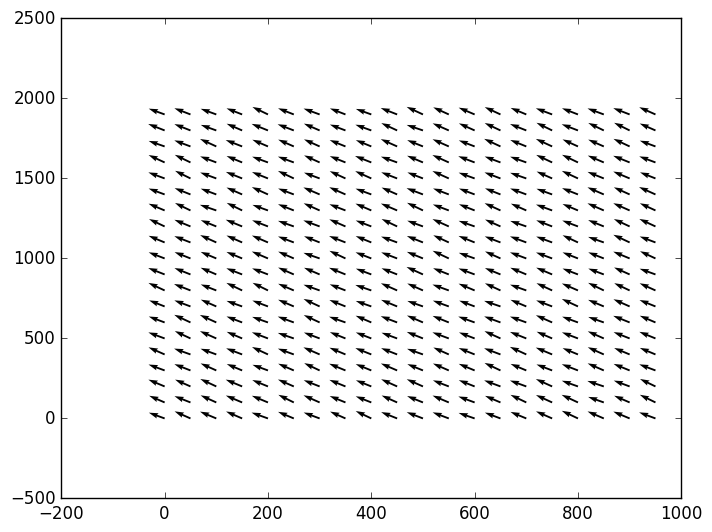

PyObject <matplotlib.quiver.Quiver object at 0x329b05f10>

In [16]:
using PyPlot
# pcolor(ETA[:,:,NT])
# quiver(x,y,uu[1:M,1:N]*1000, vv[1:M,1:N]*1000)
quiver(x[1:20,1:20],y[1:20,1:20],uu[1:20,1:20]*1000, vv[1:20,1:20]*1000)
# pcolor(x,y,sqrt(uu[1:M,1:N].^2 + vv[1:M,1:N].^2))

Now that we have the result, it is possible to make a meaningful plots with colour showing the water surface elevation and arrows the flow velocity.

In [ ]:
using PyPlot

In [ ]:
pcolor(η); colorbar(); quiver(uu[1:M,:], vv[:,1:N])
# Alternatively, we can use interpolation for the color plot to appear smoother
# imshow(η); colorbar();

In [ ]:
# The time step can be calculated with CFL criterion
for i = 1:10
    Δt = minimum(CFL * Δx ./ (sqrt(g*h) + uu[1:end-1,:]))
    println(Δt)
    # the remaining part of code is similar 
end

### Inclusion of motion due to water surface slope

Gravity acceleration due to water surface slope is very important in shallow flows and must be accounted in computation. For that reason we extend the code by including terms like `Δηx` and `Δηy` as gradients of the water surface elevation. 

In [ ]:
# assume that we know u, v

uu = -0.5 + 0.1*rand(M+1,N) 
vv = 1.0 + 0.2*rand(M,N+1) 

# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.2*rand(M,N)

uu1 = zeros(M+1,N)
vv1 = zeros(M,N+1)

Δηx = zeros(M,N)
Δηy = zeros(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)

for i = 1:1
    
    Δηx[1:end-1,:] = (η[2:end,:] - η[1:end-1,:])/Δx
    Δηy[:,1:end-1] = (η[:,2:end] - η[:,1:end-1])/Δy
    
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # Solve the momentum equation 
    uu1[1:end-1,:] = uu[1:end-1,:] - Δt * (0 - g * Δηx)
    vv1[:,1:end-1] = vv[:,1:end-1] - Δt * (0 - g * Δηy)
    
    # volume fluxes in x and y directions
    qx = uu1 .* hu
    qy = vv1 .* hv

    # Solve the continuity equation 
    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    η = η1
end

pcolor(η1); colorbar();

It is apparent that the water surface is very rough: after several time steps the lowest point on water surface barely reaches the bottom. So we must be very careful and use good techniques to avoid oscillation in simulation. The following technique is employed in [XBeach model](http://oss.deltares.nl/web/xbeach/) accounting for upwind discretization; that means a modification of `hu` and `hv` should be made.

In [ ]:
# assume that we know u, v

uu = -0.5 + 0.1*rand(M+1,N) 
vv = 1.0 + 0.2*rand(M,N+1) 

# CONSIDER to use a meaningful representation of water surface elevation
η = zeros(M,N) - 0.2*rand(M,N)

uu1 = zeros(M+1,N)
vv1 = zeros(M,N+1)

Δηx = zeros(M,N)
Δηy = zeros(M,N)

hu = zeros(M+1,N)
hv = zeros(M,N+1)

for i = 1:1
    
    Δηx[1:end-1,:] = (η[2:end,:] - η[1:end-1,:])/Δx
    Δηy[:,1:end-1] = (η[:,2:end] - η[:,1:end-1])/Δy
    
    h = η - zb

    hu[2:end-1,:] = 0.5(h[1:end-1,:] + h[2:end,:])
    hv[:,2:end-1] = 0.5(h[:,1:end-1] + h[:,2:end])

    # Solve the momentum equation 
    uu1[1:end-1,:] = uu[1:end-1,:] - Δt * (0 - g * Δηx)
    vv1[:,1:end-1] = vv[:,1:end-1] - Δt * (0 - g * Δηy)
    
    # volume fluxes in x and y directions
    qx = uu1 .* hu
    qy = vv1 .* hv

    # Solve the continuity equation 
    η1 = η - Δt * (-(qx[2:end,:] - qx[1:end-1,:])/Δx - (qy[:,2:end] - qy[:,1:end-1])/Δy )
    η = η1
end

pcolor(η1); colorbar();